# Timing Studies
____
This is the time you calculate the time...\
In this script, we fit the templates back to the subpods and determine the SPE time with respect to the LED trigger (then subtract TOF for TPC)\
Make sure you have the templates generated for both the PMTs and the LED triggers (check template folder).\
Expected about 40 minutes for TPC PMTs but depends on how many SPEs it needs to fit
____

In [1]:
import os 
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils
import tqdm
import uproot
import numba
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
import scipy

Fit subpods
___

In [2]:
runs=[7491] #subpods from which run? 
template_runs = [7491] ## templates from which run? 

In [3]:
df_templates = pd.read_pickle(f'/global/cfs/cdirs/lz/users/yqie/PMT-ANALYSIS/TimingStudies/templates/templates_TPC_{runs}.pkl') ### templates for those channels
df_triggertemplate = pd.read_pickle(f'/global/cfs/cdirs/lz/users/yqie/PMT-ANALYSIS/TimingStudies/templates/trigger_template_{template_runs}.pkl')

Fit SPEs 
___

In [4]:
all_times_ch = []
all_channels = []
all_eventnums = []
debug=False
for i in tqdm.tqdm(range(len(df_templates['channel']))):
    channel = df_templates['channel'][i]
    df_chan =  pd.read_pickle(f'/global/cfs/cdirs/lz/users/yqie/PMT-ANALYSIS/TimingStudies/run{runs}data/channel_{channel}_subpods.pkl') 
  #  df_chan = df_subpods[df_subpods['channel']==df_templates['channel'][i]].reset_index(drop=True)
    argument_of_channel = np.argwhere(df_templates['channel'].values == df_templates['channel'][i])[0][0]
    template = df_templates['templates'][argument_of_channel]
    def fit_func(x,a,b):
        return a*template(x-b)
    fit_times=[]
    temp_events=[]
    temp_channels_fail=[]
    for j in range(len(df_chan['subpods'])):
        x = np.arange(0,len(df_chan['subpods'][j]))
        try:
            popt, cov = curve_fit(fit_func, x, df_chan['subpods'][j],absolute_sigma=3,p0=[50,-7],maxfev=1000)
            x_ = np.arange(0,len(df_chan['subpods'][j]),1)
            x_fine = np.arange(0,100,.1)
            fitted_y = fit_func(x_fine,*popt)
            peak_pos_fit = x_fine[np.argwhere(fit_func(x_fine,*popt) == max(fit_func(x_fine,*popt)))]
            fit_times.append(peak_pos_fit[0][0]+df_chan['podtime'][j]) ###add subpod peak time to subpod time --> spe time rel.to t=0 
            temp_events.append(df_chan['eventnumber'][j])
        except:
            temp_channels_fail.append(channel)
    
    plt.show()
    all_times_ch.append(fit_times)
    all_channels.append(channel)
    all_eventnums.append(temp_events)


100%|██████████| 245/245 [18:18<00:00,  4.48s/it]


In [5]:
print('fit failures=',temp_channels_fail)

fit failures= []


In [6]:
df_tpcfits = pd.DataFrame(zip(all_times_ch,all_channels,all_eventnums),columns=['time_to_zero','channel','event_number'])
df_tpcfits.to_pickle(f'/global/cfs/cdirs/lz/users/yqie/PMT-ANALYSIS/TimingStudies/TPCfits{runs}.pkl')

Fit LED triggers
____

In [7]:
trigger_channel = 2101
df_triggersubpods = pd.read_pickle(f'/global/cfs/cdirs/lz/users/yqie/PMT-ANALYSIS/TimingStudies/run{runs}data/channel_{trigger_channel}_subpods.pkl')
func = df_triggertemplate['templates'][0]
trigger_times,event_numbers = [],[]
def fit_func(x,a,b):
    return a*func(x-b)
for j in tqdm.tqdm(range(len(df_triggersubpods['subpods']))):
    x = np.arange(0,len(df_triggersubpods['subpods'][j]))
    popt, cov = curve_fit(fit_func, x, df_triggersubpods['subpods'][j],absolute_sigma=3, p0=[10,-7])
    x_fine = np.arange(0,50,0.1)
    fitted_y = fit_func(x_fine,*popt)
    time_at_this = 0.9*np.max(fitted_y)
    point_90p = np.argmax(fitted_y>time_at_this)
    trigger_times.append(x_fine[point_90p] + df_triggersubpods['podtime'][j]) ###add subpod peak time to subpod time --> spe time rel.to t=0 
    event_numbers.append(df_triggersubpods['eventnumber'][j])

100%|██████████| 500000/500000 [11:23<00:00, 731.61it/s]


In [8]:
print(max(event_numbers))

104000.0


In [9]:
df_triggerfits = pd.DataFrame(zip(trigger_times,event_numbers),columns=['time_to_zero','event_number'])
df_triggerfits.to_pickle(f'/global/cfs/cdirs/lz/users/yqie/PMT-ANALYSIS/TimingStudies/triggerfits{runs}.pkl')

Find SPE time wrt LED triggers
___

In [4]:
### read above results
runs = [7491]

In [5]:
df_fits = pd.read_pickle(f'/global/cfs/cdirs/lz/users/yqie/PMT-ANALYSIS/TimingStudies/TPCfits{runs}.pkl')
df_triggerfits = pd.read_pickle(f'/global/cfs/cdirs/lz/users/yqie/PMT-ANALYSIS/TimingStudies/triggerfits{runs}.pkl')

In [6]:
final_final_times,final_final_channels = [],[]
rising_edge_times = []
OutputCh = []
Output20Rising = []
OutputNumPods = []
OutputUncertainty = []
for j in tqdm.tqdm(range(len(df_fits['channel']))):
    df_chan = df_fits[df_fits['channel']==df_fits['channel'][j]].reset_index(drop=True)
    #if(len(df_chan['event_number'][0])<200): continue
    final_times,final_channels =[],[]
    trigtime = []
    for i in range(len(df_chan['event_number'][0])):
        event=df_chan['event_number'][0][i]
        trigger_ind = np.argwhere(np.array(df_triggerfits['event_number'])==event)[0][0]
        trigger_time = df_triggerfits['time_to_zero'][trigger_ind]
        final_time = df_chan['time_to_zero'][0][i] - trigger_time
        if(final_time<50):
            continue
        final_times.append(final_time)
        final_channels.append(df_fits['channel'][j])
        trigtime.append(trigger_time)
    final_final_times.append(final_times)
    final_final_channels.append(final_channels)
    
    OutputCh.append(df_fits['channel'][j])
    OutputNumPods.append(len(final_times))
    OutputUncertainty.append(np.std(final_times))
    
    ###get rising edge here
    mini,maxi = 60,120
    binvalues, bins=np.histogram(final_times,bins=35,range=[mini,maxi])
    bincenters= (bins[:-1] + bins[1:]) / 2   
    interpfunc=scipy.interpolate.interp1d(bincenters,binvalues,'linear',fill_value=0,bounds_error=False)
    new_x = np.arange(mini,maxi,0.01)
    y = interpfunc(new_x)
    max_point = np.argwhere(y == max(y))
    point = np.argwhere(y > 0.5*max(y))
    rising_edge_times.append(new_x[point[0][0]])
    
    Output20Rising.append(new_x[point[0][0]])


100%|██████████| 245/245 [03:49<00:00,  1.07it/s]


In [7]:
final_channels_ = [item for sublist in final_final_channels for item in sublist]
final_times_= [item for sublist in final_final_times for item in sublist]

In [8]:
df_tpcfits = pd.DataFrame(zip(final_channels_,final_times_),columns=['channel','final_time'])
df_tpcfits.to_pickle(f'/global/cfs/cdirs/lz/users/yqie/PMT-ANALYSIS/TimingStudies/FinalTimeResult{runs}.pkl')

In [9]:
print(min(final_times_),max(final_times_))

70.0 110.80000000000001


In [10]:
RiseEdgeChs = [x[0] for x in final_final_channels]
print(np.mean(rising_edge_times))

73.86771428571153


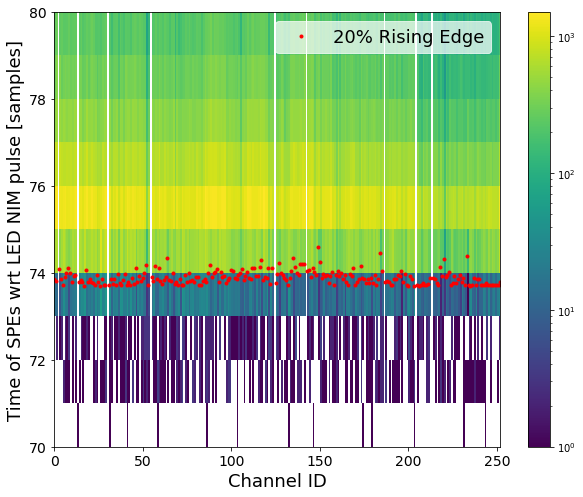

In [11]:
plt.figure(figsize=(10,8))
plt.hist2d(final_channels_,final_times_,range=[[0,252],[70,80]],bins=(252,10),norm=LogNorm())
plt.plot(RiseEdgeChs, rising_edge_times,'o',color='r',ms=3,label='20% Rising Edge')
plt.xlabel('Channel ID',fontsize=18)
plt.ylabel('Time of SPEs wrt LED NIM pulse [samples]',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar()
legend = plt.legend(frameon = 1,fontsize=18,framealpha=0.7)
frame = legend.get_frame()
frame.set_color('white')
plt.show()

In [12]:
df_output = pd.DataFrame(zip(OutputCh,Output20Rising,OutputNumPods,OutputUncertainty),columns=['Channel','20% Rising Edge','Num of Pods','STD'])

In [13]:
print(min(Output20Rising),max(Output20Rising))

68.5799999999983 74.5999999999971


In [14]:
print(df_output)
OutputName = 'Run'+str(runs)+'OutputTTPC.csv'
df_output.to_csv(OutputName,index=False)

     Channel  20% Rising Edge  Num of Pods       STD
0          0            73.86         4162  3.257904
1          1            73.82         4631  3.639201
2          3            74.09         4169  3.300663
3          4            73.86         4058  3.381058
4          5            73.73         4242  3.356967
..       ...              ...          ...       ...
240      248            73.71         2296  3.247655
241      249            73.71         2176  3.283311
242      250            73.71         2246  3.257509
243      251            73.71         2296  3.510046
244      252            73.78         1858  3.316899

[245 rows x 4 columns]


Apply TOF corrections here
____

In [15]:
topLED = False

In [16]:
pmt_pos = pd.read_csv('/cvmfs/lz.opensciencegrid.org/LZap/ConditionsDataModel/PMTpositions-LZ-26Feb20.txt',sep='\s+')
if topLED == True:
    LED = 'T10'
    array = 'Bottom'
    df_TOF = pd.read_csv('/global/cfs/cdirs/lz/users/jpalmer/PMT-ANALYSIS/FinalNotebooks/PMT_timing/timing-studies/TOF_data/bottomTPC_TopLED.csv')
    LEDpos = pd.read_csv('/global/cfs/cdirs/lz/users/jpalmer/PMT-ANALYSIS/FinalNotebooks/PMT_timing/timing-studies/TOF_data/LED Cable-MUX Mapping - Top Array LEDs.csv')
else:
    array = 'Top'
    df_TOF = pd.read_csv('/global/cfs/cdirs/lz/users/jpalmer/PMT-ANALYSIS/FinalNotebooks/PMT_timing/timing-studies/TOF_data/TopTPC_bottomLED.csv')
    LEDpos = pd.read_csv('/global/cfs/cdirs/lz/users/jpalmer/PMT-ANALYSIS/FinalNotebooks/PMT_timing/timing-studies/TOF_data/LED Cable-MUX Mapping - Bottom Array LEDs.csv')
    LED = 'B2'

Text(0, 0.5, 'Time of Flight (TOF) [ns]')

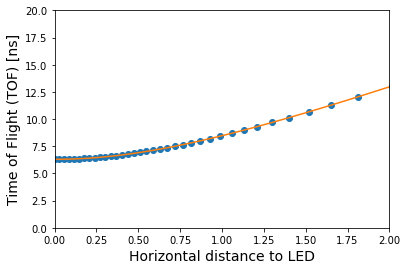

In [17]:
TOF_in_ns = df_TOF['TOF']/1e-9
plt.plot(df_TOF['deltaX'], TOF_in_ns,'o')

interpfunc=scipy.interpolate.interp1d(df_TOF['deltaX'][0:60], TOF_in_ns[0:60],'linear',fill_value=0,bounds_error=False)
plt.plot(df_TOF['deltaX'][0:60],interpfunc(df_TOF['deltaX'][0:60]))
plt.xlim(0,2)
# plt.ylim(0,max(TOF_in_ns[0:60]))
plt.ylim(0,20)
plt.xlabel('Horizontal distance to LED',fontsize=14)
plt.ylabel('Time of Flight (TOF) [ns]',fontsize=14)

In [18]:
def pmt_to_led_TOF(pmtpos, ledpos, lednumber, pmtnumber, TOF_func):
    ledpos = ledpos[ledpos['Index'] == lednumber].reset_index(drop=True)
    pmtpos = pmtpos[pmtpos['Channel'] == pmtnumber].reset_index(drop=True)
    distance = np.sqrt((ledpos['x (cm)']/100 - pmtpos['Xpos']/1000)**2 + (ledpos['y (cm)']/100 - pmtpos['Ypos']/1000)**2)
    TOF = TOF_func(distance)
    return TOF[0]

In [19]:
pmt_to_led_TOF(pmt_pos, LEDpos, LED,540,interpfunc)

7.863256100370042

In [21]:
df_risingEdge = pd.read_csv('Run[7491]OutputTTPC.csv')
all_channels=np.array(df_risingEdge['Channel'])
rising_edge_times = np.array(df_risingEdge['20% Rising Edge'])
NumofPods = np.array(df_risingEdge['Num of Pods'])
STD = np.array(df_risingEdge['STD'])
print(np.array(all_channels))

[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 205 206 207 208 209 210 211 212 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252]


In [22]:
Corrected_time,TOFs = [],[]
channel_corr = []
for i in tqdm.tqdm(range(len(all_channels))):
    channel = all_channels[i]
    if topLED == False:
        if channel < 300:
            TOF = pmt_to_led_TOF(pmt_pos, LEDpos, LED,channel,interpfunc)/10.
            TOFs.append(TOF)
            rising_time = rising_edge_times[np.where(all_channels==channel)[0][0]]
            Corrected_time.append(rising_time - TOF)
            channel_corr.append(channel)
    else:
        if channel >=300:
            TOF = pmt_to_led_TOF(pmt_pos, LEDpos, LED,channel,interpfunc)/10.
            TOFs.append(TOF)
            rising_time = rising_edge_times[np.where(all_channels==channel)[0][0]]
            Corrected_time.append(rising_time - TOF)
            channel_corr.append(channel)

100%|██████████| 245/245 [00:00<00:00, 906.77it/s]


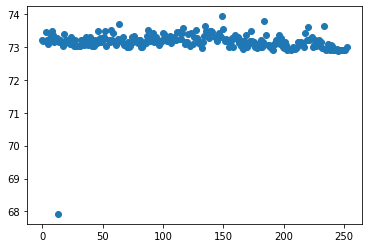

In [23]:
plt.plot(channel_corr,Corrected_time,'o')

In [24]:
finalCorr = [int((v-70)*10) for v in Corrected_time]
Corrected_time = [int(v*10) for v in Corrected_time]

In [11]:
df_output = pd.DataFrame(zip(all_channels,finalCorr,Corrected_time,NumofPods),columns=['Channel','Time Correction (ns)','20% Rising Edge (ns)','NumofPods'])
print(df_output)
OutputName = 'TTPCOutput7492TOF.csv'
df_output.to_csv(OutputName,index=False)

     Channel  Time Correction (ns)  20% Rising Edge (ns)  NumofPods
0          0                    29                   729       3570
1          1                    30                   730       3943
2          3                    32                   732       3712
3          4                    29                   729       3535
4          5                    28                   728       3540
..       ...                   ...                   ...        ...
239      248                    27                   727       1742
240      249                    27                   727       1642
241      250                    28                   728       1797
242      251                    26                   726       1734
243      252                    29                   729       1443

[244 rows x 4 columns]
